In [1]:
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid 
from torch.utils.tensorboard import SummaryWriter


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [3]:
writer = SummaryWriter()

In [4]:
# Load datasets from disk with transforms applied
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for CNNs
    transforms.ToTensor()])

train_data = datasets.INaturalist(root='data/train_mini', version="2021_train_mini", transform=transform, download=False)

train_data_sample_indices = random.sample(range(len(train_data)), 10000)


imgs = torch.stack([train_data[i][0] for i in train_data_sample_indices], dim=3)
sample_mean = imgs.view(3, -1).mean(dim=1)
sample_std = imgs.view(3, -1).std(dim=1)

In [5]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224))   ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),    
    transforms.ToTensor(),
    transforms.Normalize(mean=sample_mean, std=sample_std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224))   ,
    transforms.ToTensor(), 
    transforms.Normalize(mean=sample_mean, std=sample_std)
])



# Load datasets from disk with transforms applied
train_data = datasets.INaturalist(root='data/train_mini', version="2021_train_mini", transform=train_transform, download=False)
validation_data = datasets.INaturalist(root='data/validation', version="2021_valid", transform=val_transform, download=False)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_data, batch_size=128, shuffle=True, num_workers=4)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(validation_data)}")

Training samples: 500000
Validation samples: 100000


In [6]:
cat_list = [int(cat[1:5]) for cat in train_data.all_categories if "Animalia_Chordata_Aves" in cat]
# get corresponding labels

In [7]:
# bird_indices = []
# for i, (_, label) in enumerate(train_data):
#     print(i, label)
#     if label > 4596:
#         break
#     if label >= 3111 and label <= 4596:
#         bird_indices.append(i)

In [8]:
# with open('bird_indices.txt', 'w') as f:
#     for line in bird_indices:
#         f.write(f"{line}\n")

In [9]:
bird_indices = []
with open('bird_indices.txt', 'r') as f:
    for line in f:
        bird_indices.append(int(line[0:-1]))

In [10]:
# bird_val_indices = []
# for i, (_, label) in enumerate(validation_data):
#     if label > 4596:
#         break
#     if label >= 3111 and label <= 4596:
#         bird_val_indices.append(i)

In [11]:
# with open('bird_val_indices.txt', 'w') as f:
#     for line in bird_val_indices:
#         f.write(f"{line}\n")

In [12]:
bird_val_indices = []
with open('bird_val_indices.txt', 'r') as f:
    for line in f:
        bird_val_indices.append(int(line[0:-1]))

In [13]:
from torch.utils.data import Subset

# Find all indices where the target (label) corresponds to birds
# Create a subset dataset containing only birds
train_data_birds = Subset(train_data, bird_indices)

# Create a DataLoader for the filtered dataset
train_loader_birds = DataLoader(train_data_birds, batch_size=32, shuffle=True, num_workers=4)

val_data_birds = Subset(validation_data, bird_val_indices)
val_loader_birds = DataLoader(val_data_birds, batch_size=32, shuffle=True, num_workers=4)

print(f"Filtered train dataset contains {len(train_data_birds)} bird images.")
print(f"Filtered val dataset contains {len(val_data_birds)} bird images.")

Filtered train dataset contains 74300 bird images.
Filtered val dataset contains 14860 bird images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


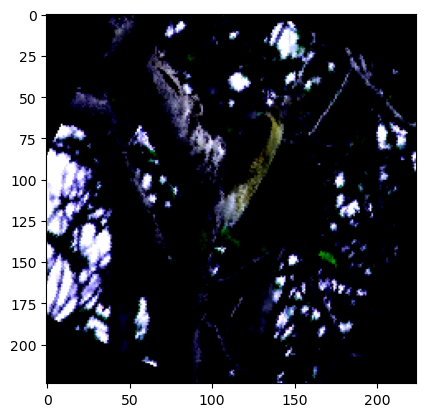

In [14]:
plt.imshow(train_data_birds[1][0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


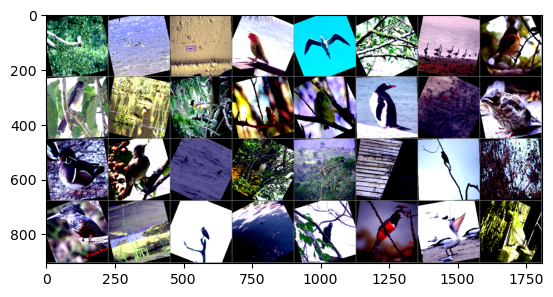

In [15]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader_birds)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

In [16]:
n_classes = len(cat_list)
n_classes

1486

In [17]:
def remap_labels(labels):
    return (labels - 3111).long()  # Convert labels to tensor and ensure they are Long type


def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()  # Set to training mode

    train_n = len(train_loader)
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            labels = remap_labels(labels).to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        # Print epoch stats
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {100 * correct / total:.2f}%")


In [18]:
torch.cuda.empty_cache()

In [19]:
# Define a Simple CNN Model
class SimpleCNN_2(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN_2, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm2d(128)


        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 14 * 14, 2000)  # 64 channels, 28x28 image size after pooling
        self.fc2 = nn.Linear(2000, num_classes)   # Output layer
        
        # Dropout to prevent overfitting
        self.conv_dropout = nn.Dropout2d(0.3)
        self.conv2_dropout = nn.Dropout2d(0.3)
        self.conv3_dropout = nn.Dropout2d(0.3)
        self.conv4_dropout = nn.Dropout2d(0.3)
    
    def forward(self, x):
        x = self.pool(self.batchnorm1(F.relu(self.conv1(x))))  # Conv1 -> ReLU -> MaxPool
        x = self.conv_dropout(x)
        x = self.pool(self.batchnorm2(F.relu(self.conv2(x))))  # Conv2 -> ReLU -> MaxPool
        x = self.conv2_dropout(x)
        x = self.pool(self.batchnorm3(F.relu(self.conv3(x))))  # Conv3 -> ReLU -> MaxPool
        x = self.conv3_dropout(x)
        x = self.pool(self.batchnorm4(F.relu(self.conv4(x))))  # Conv4 -> ReLU -> MaxPool
        x = self.conv4_dropout(x)
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer
        return x

In [ ]:
def evaluate_model(model, val_loader, criterion, epoch):
    model.eval()  # Set to evaluation mode
    running_loss = 0.0
    top_5_correct = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = remap_labels(labels).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute loss
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()
            _, top_5_predicted = outputs.topk(5, dim=1)
            top_5_correct += torch.isin(labels, predicted).sum().item()
            #top_5_correct += (top_5_predicted == labels.view(-1, 1)).sum().item()  # labels.view(-1,1) expands dims for comparison

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")
    print(f"Top 5 validation Accuracy: {100 * top_5_correct / total:.2f}%")
    writer.add_scalar("Loss - test", loss, epoch)
    writer.add_scalar("Running loss - test", running_loss/len(val_loader), epoch)
    writer.add_scalar("Accuracy - test", 100 * correct / total, epoch)
    writer.add_scalar("Top 5 validation Accuracy", 100 * top_5_correct / total, epoch)

    return


def train_model_eval(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    model.train()  # Set to training mode

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            labels = remap_labels(labels).to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        # Print epoch stats
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {100 * correct / total:.2f}%")
        writer.add_scalar("Loss - train", loss, epoch)
        writer.add_scalar("Running loss - train", running_loss/len(train_loader), epoch)
        writer.add_scalar("Accuracy - train", 100 * correct / total, epoch)
        evaluate_model(model, val_loader, criterion, epoch)

        if epoch % 5 == 0 :
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, "runs/models/simple_cnn.pt")


In [21]:
# save model
# store eval scores for plotting 
# stopping criteria? i.e when does val score not descrease for n consecutive epochs

simple_cnn_2 = SimpleCNN_2(num_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(simple_cnn_2.parameters(), lr=0.0001)


# Train the model
train_model_eval(simple_cnn_2, train_loader_birds, val_loader_birds, criterion, optimizer, epochs=100)

Epoch 1/100 - Loss: 7.2779 - Accuracy: 0.09%
Validation Accuracy: 0.13%
Top 5 validation Accuracy: 0.65%
Epoch 2/100 - Loss: 7.0710 - Accuracy: 0.22%
Validation Accuracy: 0.36%
Top 5 validation Accuracy: 1.60%
Epoch 3/100 - Loss: 6.8556 - Accuracy: 0.38%
Validation Accuracy: 0.52%
Top 5 validation Accuracy: 2.19%
Epoch 4/100 - Loss: 6.7291 - Accuracy: 0.51%
Validation Accuracy: 0.56%
Top 5 validation Accuracy: 2.74%
Epoch 5/100 - Loss: 6.6346 - Accuracy: 0.77%
Validation Accuracy: 0.84%
Top 5 validation Accuracy: 3.26%
Epoch 6/100 - Loss: 6.5478 - Accuracy: 0.89%
Validation Accuracy: 0.87%
Top 5 validation Accuracy: 3.61%
Epoch 7/100 - Loss: 6.4682 - Accuracy: 1.05%
Validation Accuracy: 0.89%
Top 5 validation Accuracy: 4.15%
Epoch 8/100 - Loss: 6.3749 - Accuracy: 1.42%
Validation Accuracy: 1.27%
Top 5 validation Accuracy: 4.78%
Epoch 9/100 - Loss: 6.2820 - Accuracy: 1.62%
Validation Accuracy: 1.18%
Top 5 validation Accuracy: 4.96%
Epoch 10/100 - Loss: 6.1820 - Accuracy: 1.92%
Validatio

KeyboardInterrupt: 

In [ ]:
bird_classes = [cat for cat in train_data.all_categories if "Animalia_Chordata_Aves" in cat]

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in bird_classes}
total_pred = {classname: 0 for classname in bird_classes}

# again no gradients needed
with torch.no_grad():
    for data in val_loader_birds:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels = remap_labels(labels).to(device)
        outputs = simple_cnn_2(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[bird_classes[label]] += 1
            total_pred[bird_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')